목표 : 웨이퍼 결함 데이터셋 EDA 및 분류 모델 구축1(object-detection)  
타깃 논문 : Novel method for detection of mixed‑type defect patterns in wafer maps based on a single shot detector algorithm 

[논문 요약]
웨이퍼 데이터의 다중결함 상태 진단을 위해 SSD를 사용했으며, Base CNN models보다 accuracy가 향상되었음  

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


data load

In [ ]:
df=pd.read_pickle("/content/drive/Shareddrives/TNT/정규세션/2022년 1학기/산업 인공지능/TASK2-wafer map /LSWMD.pkl")

EDA  
EDA를 통해 데이터가 어떠한 형태인지 알아보세요! ex)열별로 데이터 종류, 개수 세보기, 데이터 불균형 상태인지 막대 그래프 그려보기, wafermap을 failure Type별로 그려보기 등등...

In [ ]:
df.info() #결측치 모두 없다!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
 6   waferMapDim     811457 non-null  object 
dtypes: float64(2), object(5)
memory usage: 43.3+ MB


In [ ]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]],"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]],"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]],"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]],"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]],"(45, 48)"


In [ ]:
df.tail() #전체 데이터 개수 : 811456

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]],"(26, 30)"
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]],"(26, 30)"
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]],"(26, 30)"
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[],"(26, 30)"
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[],"(26, 30)"


In [ ]:
#TrainTestLabel 's [[]] remove
def removebrackets(array):
    if array.shape == (1, 1):
        return "".join(array[0])
    elif array.shape == (0, 0):
        return None
        
#column rename
df.rename(columns = {'trianTestLabel':'TrainTestLabel'}, inplace = 'True')
df['TrainTestLabel'] = df['TrainTestLabel'].apply(removebrackets)
df['failureType'] = df['failureType'].apply(removebrackets)

In [ ]:
df #[[]] are removed

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none,"(45, 48)"
...,...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring,"(26, 30)"
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc,"(26, 30)"
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,Test,Edge-Ring,"(26, 30)"
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,None,None,"(26, 30)"


In [ ]:
df.isna().sum() 

waferMap               0
dieSize                0
lotName                0
waferIndex             0
TrainTestLabel    638507
failureType       638507
waferMapDim            0
dtype: int64

In [ ]:
df.columns.tolist() #열의 이름

['waferMap',
 'dieSize',
 'lotName',
 'waferIndex',
 'TrainTestLabel',
 'failureType',
 'waferMapDim']

In [ ]:
# waferMap에 적힌 수가 많아 몇개인지세봄.
len(df['waferMap'][0][0])

48

Wafer-Map : 기판 표면에 있는 반도체 소자의 성능을 색상으로 구분된 그리드의 생성을 통해 시각화하는 공정  
- diesize : 집적회로의의 길이와 폭, 다이 사이즈와 형상은 특정 프로세스 노드 상의 특정 크기의 단일 웨이퍼에서 실현할 수 있는 총 다이 수를 결정하기 때문에 다이 사이즈는 제조 코스트의 강력한 지표이다. (집적회로 : 반도체에 만든 전자회로의 집합)


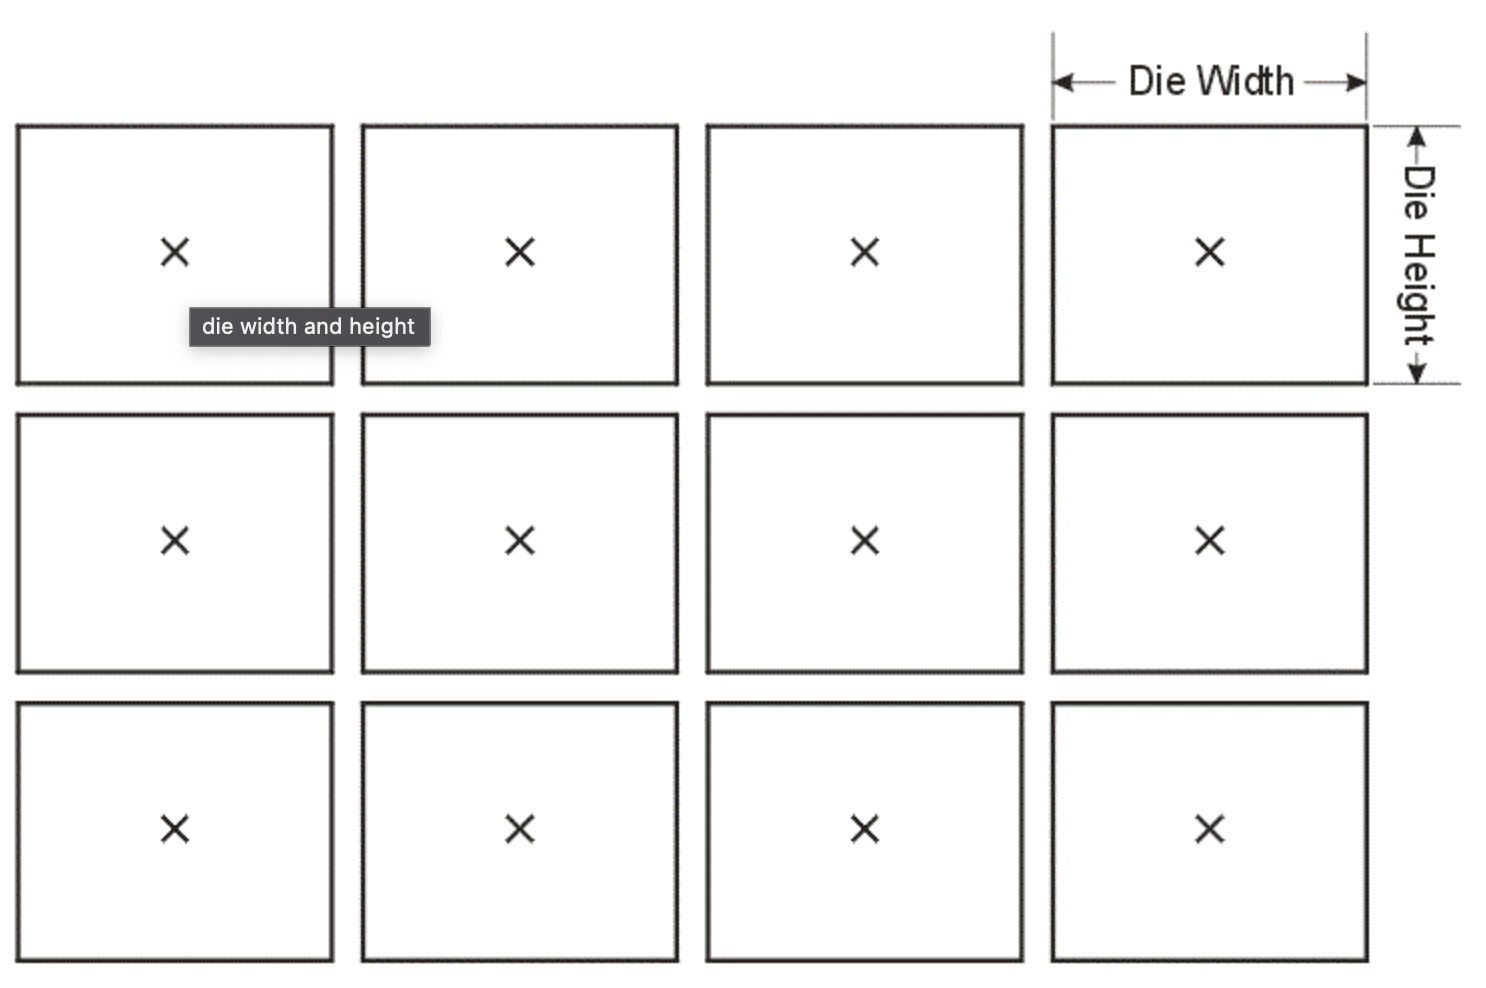





- lotName : 


- lotName : lotID = lot ID는 팹이 로트에 할당한 번호 또는 문자열입니다. 일반적으로 웨이퍼에 식각되어 있어 사람과 기계가 읽을 수 있습니다.
- waferIndex: 로트내의 각각 웨이퍼에는 고유한 번호 또는 문자열이 할당된다.
- failureType : 결함 type
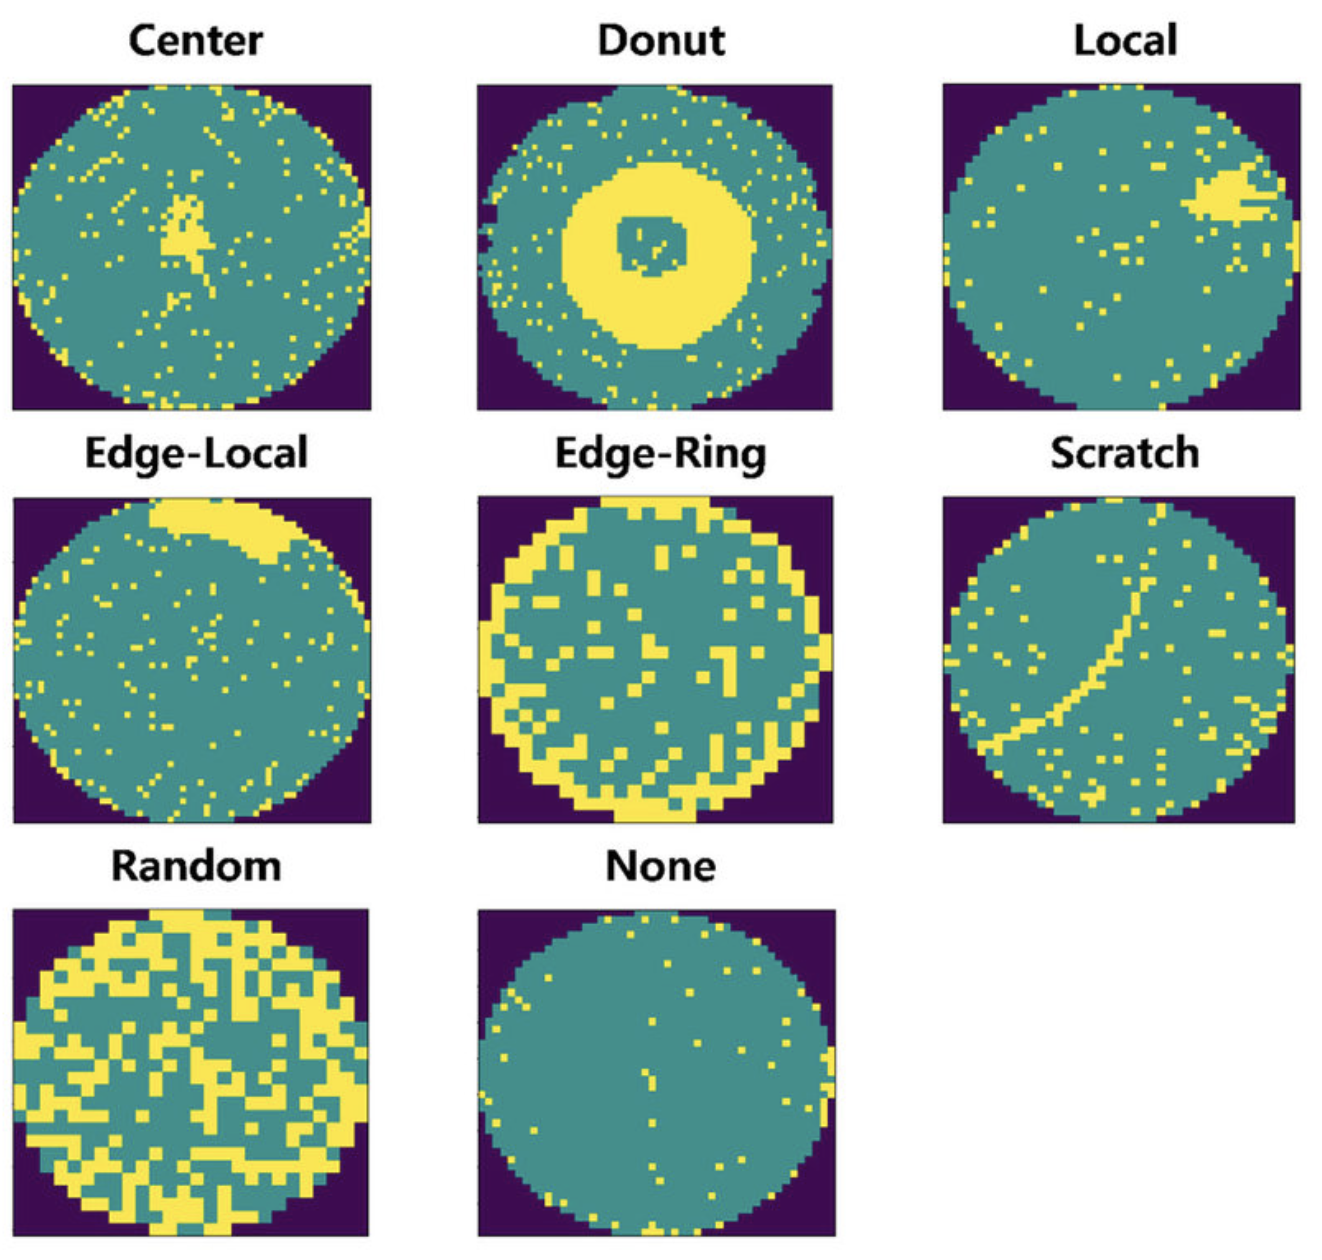

New Insight of data  
- 조사결과 LOT 은 wafer 25을 묶음부르는 표현
- 1 lot = 25 wafers
- 데이터에서 wafer index 가 1~25까지 존재, lot Name과 waferindex 는 사실 비슷한 넘버링 표현(1lot마다 1~25 waferindex가 돌아감)  

waferindex별로 균일한 분포를 보여야하지만, 데이터에서는 결측치가 존재하는 것으로 보임. 그러나 classification에서 사진의 순서는 중요치 않다고 생각해 waferindex와 lotName은 고려하지 않음.


추후 : traintest label이 어떤 비율로 이루어져 있고 random하게 분포되어 있는지 정렬되어 있는지 뜯어볼 생각이다.  
failureType이 어떻게 분포되어 있는지  
도식화 시켜볼 계획이다.

check list
- 예측해야하는 타겟값분포포
- 결측치, 이상치
- 분류상상 유의미한 데이터인지

data summary



In [ ]:
df

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none,"(45, 48)"
...,...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring,"(26, 30)"
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc,"(26, 30)"
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,Test,Edge-Ring,"(26, 30)"
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,None,None,"(26, 30)"


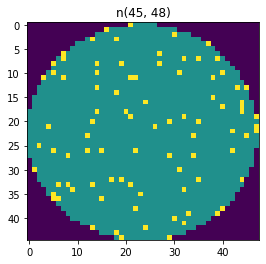

In [ ]:
idx=0
img=df['waferMap'][idx] # 결함 그래프가 그려진다.
#df['failureType'][idx] : 감싸진 array 형태이기 때문에 [0][0]해주어야 string을 출력할 수 있다.
plt.title(df['failureType'][idx][0][0]+str(img.shape)) #사이즈까지 함께 출력
plt.imshow(img)

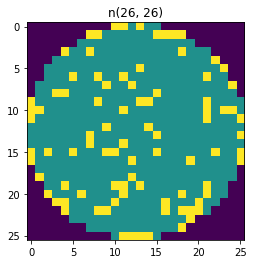

In [ ]:
idx=1000
img=df['waferMap'][idx]
#df['failureType'][idx] : 감싸진 array 형태이기 때문에 [0][0]해주어야 string을 출력할 수 있다.
plt.title(df['failureType'][idx][0][0]+str(img.shape)) #사이즈까지 함께 출력
plt.imshow(img)

#그림사이즈가 매우 다름.

In [ ]:
#diesize
df['dieSize'].value_counts()

710.0     66961
515.0     45725
712.0     42572
1513.0    39322
776.0     29513
          ...  
2322.0        1
2309.0        1
2277.0        1
2273.0        1
586.0         1
Name: dieSize, Length: 1266, dtype: int64

In [ ]:
type(df['dieSize'][0])
print(type(df.dieSize))

#dieSize_li=[]
#for i in df.dieSize:
#  dieSize_li.append(i)
#df['dieSize'].values()

<class 'pandas.core.series.Series'>


In [ ]:
df.dieSize

0         1683.0
1         1683.0
2         1683.0
3         1683.0
4         1683.0
           ...  
811452     600.0
811453     600.0
811454     600.0
811455     600.0
811456     600.0
Name: dieSize, Length: 811457, dtype: float64

In [ ]:
#웨이퍼 맵 컬럼에서는 많은 정보를 얻을 수 없지만 인스턴스마다 다이 사이즈가 다르다는 것을 알 수 있습니다.

In [ ]:
#diesize의 분포
#import matplotlib.pyplot as plt
#%matplotlib inline

#print(type(uni_Index[0]))
#print(type(df.dieSize))
#die_arr=np.array(df.dieSize)
#print(type(die_arr))

#plt.bar(die_arr,uni_Index[0],align='center',alpha=0.5)
#plt.title("diesize according to wafer index")
#plt.xlabel("wafer index")
#plt.ylabel("diesize")
#plt.show()

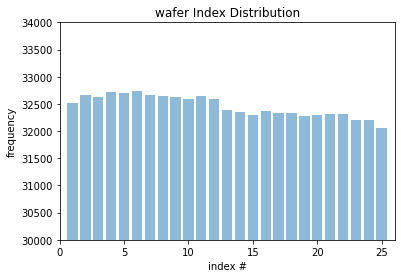

In [ ]:
# waferIndex의의 분포
import matplotlib.pyplot as plt
%matplotlib inline
#unique : Train data의 class 별 입력input 개수알고싶을때
uni_Index=np.unique(df.waferIndex, return_counts=True)

#          x           y
plt.bar(uni_Index[0], uni_Index[1], align='center', alpha=0.5)
plt.title("wafer Index Distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [ ]:
df.waferIndex

0          1.0
1          2.0
2          3.0
3          4.0
4          5.0
          ... 
811452    23.0
811453    24.0
811454    25.0
811455     1.0
811456     2.0
Name: waferIndex, Length: 811457, dtype: float64

In [ ]:
uni_Index

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 array([32516, 32663, 32621, 32714, 32701, 32745, 32672, 32650, 32636,
        32586, 32637, 32598, 32381, 32353, 32301, 32362, 32333, 32333,
        32285, 32290, 32320, 32312, 32202, 32197, 32049]))

In [ ]:
#waferIndex no need
#df = df.drop(['waferIndex'], axis = 1)

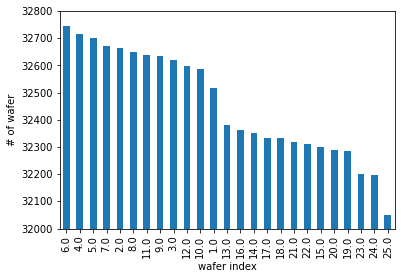

In [ ]:
df.waferIndex.value_counts().plot.bar(ylim=(32000,32800),xlabel='wafer index',ylabel='# of wafer')

In [ ]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0, dim1
    
df['waferMapDim']=df.waferMap.apply(find_dim)

In [ ]:
df.sample(5)

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType,waferMapDim
296738,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6052.0,lot18125,9.0,None,None,"(86, 89)"
188388,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot12003,11.0,None,None,"(53, 58)"
175053,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2393.0,lot11189,5.0,None,None,"(52, 59)"
795854,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2,...",562.0,lot46907,20.0,Test,none,"(29, 26)"
556399,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,...",515.0,lot34922,2.0,None,None,"(25, 27)"


In [ ]:
df.info()
#waferMapDim값이 생성되었다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   TrainTestLabel  172950 non-null  object 
 5   failureType     172950 non-null  object 
 6   waferMapDim     811457 non-null  object 
dtypes: float64(2), object(5)
memory usage: 43.3+ MB


In [ ]:
df.shape

(811457, 7)

In [ ]:
df

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none,"(45, 48)"
...,...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring,"(26, 30)"
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc,"(26, 30)"
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,Test,Edge-Ring,"(26, 30)"
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,None,None,"(26, 30)"


In [ ]:
df=df.dropna(subset=['failureType'])
df
# failureType na remove

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none,"(45, 48)"
...,...,...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc,"(26, 30)"
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc,"(26, 30)"
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring,"(26, 30)"
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc,"(26, 30)"


In [ ]:
df['failureNum']=df.failureType
df['trainTestNum']=df.TrainTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [ ]:
df

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none,"(45, 48)",8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none,"(45, 48)",8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none,"(45, 48)",8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none,"(45, 48)",8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none,"(45, 48)",8,0
...,...,...,...,...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc,"(26, 30)",2,1
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc,"(26, 30)",2,1
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring,"(26, 30)",3,1
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc,"(26, 30)",2,1


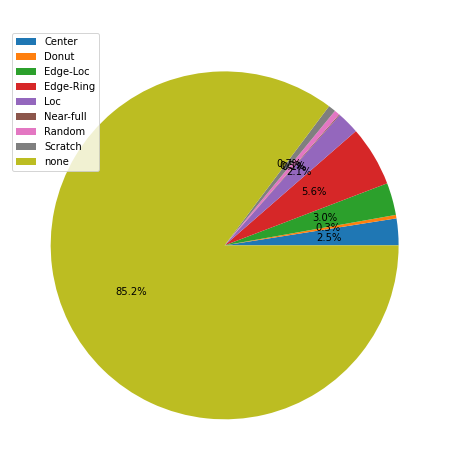

In [ ]:
# failuretype
#none most 
label = df.failureType.values

plt.figure(figsize=(8, 8))
labels = np.unique(label, return_counts=True)[0]
counts = np.unique(label, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

In [ ]:
#failuretype이이 none
df[df['failureType'] == 'none']

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none,"(45, 48)",8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none,"(45, 48)",8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none,"(45, 48)",8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none,"(45, 48)",8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none,"(45, 48)",8,0
...,...,...,...,...,...,...,...,...,...
811438,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,9.0,Test,none,"(26, 30)",8,1
811439,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,10.0,Test,none,"(26, 30)",8,1
811442,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,...",600.0,lot47542,13.0,Test,none,"(26, 30)",8,1
811445,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,16.0,Test,none,"(26, 30)",8,1


In [ ]:
pattern=df[df['failureType']!='none']
pattern

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType,waferMapDim,failureNum,trainTestNum
19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,Training,Loc,"(45, 48)",4,0
36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,Training,Edge-Loc,"(53, 58)",2,0
37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,Training,Edge-Loc,"(53, 58)",2,0
38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,Training,Edge-Loc,"(53, 58)",2,0
39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,Training,Edge-Loc,"(53, 58)",2,0
...,...,...,...,...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc,"(26, 30)",2,1
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc,"(26, 30)",2,1
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring,"(26, 30)",3,1
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc,"(26, 30)",2,1


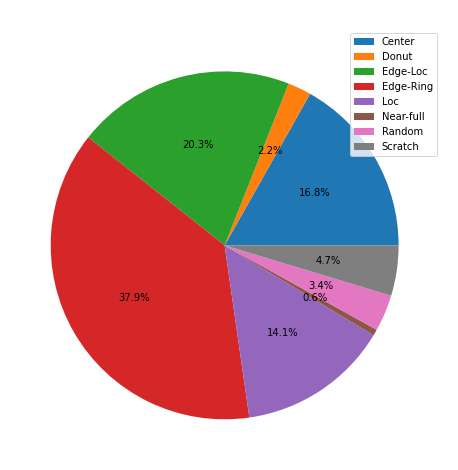

In [ ]:
label = pattern.failureType.values

plt.figure(figsize=(8, 8))
labels = np.unique(label, return_counts=True)[0]
counts = np.unique(label, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

In [ ]:
#lotName is not important

In [ ]:
df['lotName']

0             lot1
1             lot1
2             lot1
3             lot1
4             lot1
            ...   
811450    lot47542
811451    lot47542
811452    lot47542
811453    lot47542
811454    lot47542
Name: lotName, Length: 172950, dtype: object

In [ ]:
df.lotName.value_counts()

lot1        25
lot43909    25
lot43923    25
lot43922    25
lot43921    25
            ..
lot33971     1
lot33988     1
lot34071     1
lot34081     1
lot18799     1
Name: lotName, Length: 10762, dtype: int64

In [ ]:
df.lotName.value_counts().value_counts()
#25 의 개수 : 21762

25    4415
1     2441
24     697
2      519
23     508
22     387
21     320
3      234
20     177
4      150
5      111
19     109
6      105
18      72
7       70
8       60
17      49
15      48
9       47
16      45
12      43
14      43
13      39
10      38
11      35
Name: lotName, dtype: int64

In [ ]:
pd.DataFrame.plot? #xlabel 등을 검색할 수 있음.

In [ ]:
df.lotName.value_counts().unique()

array([25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,
        8,  7,  6,  5,  4,  3,  2,  1])

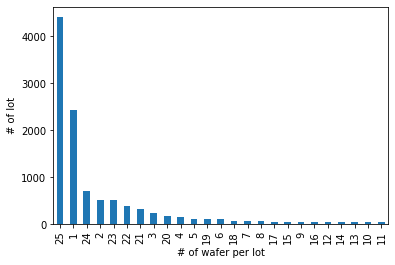

In [ ]:
bar_=df.lotName.value_counts().value_counts().plot.bar(xlabel='# of wafer per lot', ylabel='# of lot')
bar_

In [ ]:
df

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none,"(45, 48)",8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none,"(45, 48)",8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none,"(45, 48)",8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none,"(45, 48)",8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none,"(45, 48)",8,0
...,...,...,...,...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc,"(26, 30)",2,1
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc,"(26, 30)",2,1
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring,"(26, 30)",3,1
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc,"(26, 30)",2,1


In [ ]:
df.TrainTestLabel.value_counts()

Test        118595
Training     54355
Name: TrainTestLabel, dtype: int64

In [ ]:
data={'Test':118595,'Training':54355}
traintest=pd.DataFrame(data,index=['a'])
traintest

,Test,Training
a,118595,54355


In [ ]:
tot=traintest['Test']+traintest['Training']

print("Test비율=%f%%" %(traintest['Test']/tot * 100))
print("Train비율=%f%%" %(traintest['Training']/tot * 100))

Test비율=68.571842%
Train비율=31.428158%


([<matplotlib.patches.Wedge at 0x7fca54467bd0>,
 [Text(-0.6059985949805725, 0.9180227137067863, 'Test'),
  Text(0.6059985949805724, -0.9180227137067866, 'Training')],
 [Text(-0.33054468817122135, 0.5007396620218835, '68.6%'),
  Text(0.33054468817122123, -0.5007396620218835, '31.4%')])

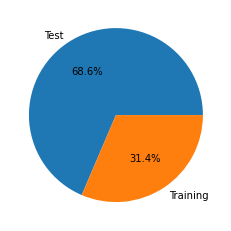

In [ ]:
plt.pie((traintest['Test'],traintest['Training']),labels=['Test','Training'],autopct='%1.1f%%')

In [ ]:
#Train : Test를 7:3 정도가 적당 but test_data>train_data
tmp=df
tmp

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none,"(45, 48)",8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none,"(45, 48)",8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none,"(45, 48)",8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none,"(45, 48)",8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none,"(45, 48)",8,0
...,...,...,...,...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc,"(26, 30)",2,1
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc,"(26, 30)",2,1
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring,"(26, 30)",3,1
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc,"(26, 30)",2,1


In [ ]:
type(tmp['trainTestNum'])
tmp['traintestNum']=tmp['trainTestNum'].astype(int)
tmp['trainTestNum']

0         0
1         0
2         0
3         0
4         0
         ..
811450    1
811451    1
811452    1
811453    1
811454    1
Name: trainTestNum, Length: 172950, dtype: int64

In [ ]:
sum(tmp['trainTestNum'])

118595

In [ ]:
a=tmp.sample(n=1)
a

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType,waferMapDim,failureNum,trainTestNum,traintestNum
59536,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1801.0,lot4715,24.0,Training,Edge-Loc,"(56, 41)",2,0,0


In [ ]:
print(a.index)
print(type(a.index))

Int64Index([59536], dtype='int64')
<class 'pandas.core.indexes.numeric.Int64Index'>


In [ ]:
print(a['trainTestNum'])
type(a['trainTestNum'])

59536    0
Name: trainTestNum, dtype: int64


pandas.core.series.Series

In [ ]:
#'Training':0,'Test':1
#a=tmp.sample(n=1)
#a
for i in tmp:
  a=tmp.sample(n=1)

#  print(a)
  #print('\n')
  
  #print(a['trainTestNum'])
  #break
  #posi=a[]
  if a['trainTestNum']==1:
    a['traintestNum']=0

  if sum(tmp['traintestNum'])/len(tmp) <=0.3:
    break

ValueError: ignored